# Homework 2

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-08

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the corporate and government bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`, containing EOD price data as of 2024-12-13.

------------------------------------------------------------------------------------------
# Problem 1: Constructing fixed rate bonds

In [1]:
import QuantLib as ql
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

today = pd.to_datetime("2024-12-13") 
days_per_year = 365.25

## a. Prepare the symbology and market data files for fixed rate government and corporate bonds

Load the `bond_symbology`, `bond_market_prices_eod` and `govt_on_the_run` Excel files into dataframes. Filter the symbology frame for fixed rate bonds only (cpn_type="FIXED").


In [2]:
# Load bond_symbology
bond_symbology = pd.read_excel("data/bond_symbology.xlsx")
bond_symbology['start_date'] = pd.to_datetime(bond_symbology['start_date'])
bond_symbology['cpn_first'] = pd.to_datetime(bond_symbology['cpn_first'])
bond_symbology['acc_first'] = pd.to_datetime(bond_symbology['acc_first'])
bond_symbology['maturity']   = pd.to_datetime(bond_symbology['maturity'])

bond_symbology['term'] = ((bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / days_per_year)
bond_symbology['TTM'] = ((bond_symbology['maturity'] - today).dt.days / days_per_year)
bond_symbology['TTM'] = bond_symbology['TTM'].apply(lambda x: x if x > 0 else 0)

display(bond_symbology.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.413415
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.001369,1.196441


In [3]:
fixed_rate_bonds = bond_symbology[bond_symbology['cpn_type'] == 'FIXED']
fixed_rate_bonds.head()

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.413415
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.001369,1.196441


In [4]:
# Load bond_market_prices_eod
bond_market_prices_eod = pd.read_excel("data/bond_market_prices_eod.xlsx")
bond_market_prices_eod["date"] = pd.to_datetime(bond_market_prices_eod["date"])
display(bond_market_prices_eod.head())

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177


In [5]:
govt_on_the_run = pd.read_excel("data/govt_on_the_run.xlsx")
on_the_run_list = ["2Y","3Y","5Y","7Y","10Y","20Y","30Y"]
pattern = r"^GT(\d+)([A-Z])?\sGovt$"
govt_on_the_run[["tenor", "suffix"]] = govt_on_the_run["ticker"].str.extract(pattern)
govt_on_the_run["tenor"] = govt_on_the_run["tenor"] + "Y"
display(govt_on_the_run.head())

,ticker,date,figi,isin,tenor,suffix
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90,10Y,NaN
1,GT10B Govt,2024-12-13,BBG01P1YBJQ5,US91282CLF67,10Y,B
2,GT10C Govt,2024-12-13,BBG01MPC8VJ9,US91282CKQ32,10Y,C
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56,2Y,NaN
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39,20Y,NaN


## b. Add a function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [6]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [7]:
def create_schedule_from_symbology(details: dict):
    maturity = get_ql_date(details["maturity"])
    acc_first = get_ql_date(details["acc_first"])
    
    freq_map = {1: ql.Period(ql.Annual), 2: ql.Period(ql.Semiannual), 4: ql.Period(ql.Quarterly), 12: ql.Period(ql.Monthly)}
    period = freq_map[details["cpn_freq"]]
    
    if details["class"] == "Govt":
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    else:
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

    business_day_convention = ql.Unadjusted
    termination_date_convention = ql.Unadjusted
    date_generation=ql.DateGeneration.Backward
        
    schedule = ql.MakeSchedule(
        effectiveDate=acc_first,
        terminationDate=maturity,
        tenor=period,
        calendar=calendar,
        convention=business_day_convention,
        terminalDateConvention=termination_date_convention,
        rule=date_generation,
        endOfMonth=True,
        firstDate=get_ql_date(details["cpn_first"]), # Check!
        nextToLastDate=ql.Date()
    )
    return schedule

In [8]:
schedule = pd.DataFrame(list(create_schedule_from_symbology(fixed_rate_bonds.iloc[0].to_dict())), columns=["dates"])
display(schedule)

,dates
0,"May 3rd, 2013"
1,"November 4th, 2013"
2,"May 4th, 2014"
3,"November 4th, 2014"
4,"May 4th, 2015"
...,...
56,"May 4th, 2041"
57,"November 4th, 2041"
58,"May 4th, 2042"
59,"November 4th, 2042"


## c. Add a function to construct generic fixed rate bond objects from symbology data

Implement the  create_schedule_from_symbology() function below. 

Identify and display the `AAPL 2.2 09/11/29` bond details in the symbology dataframe. Use create_schedule_from_symbology() to generate and display the cashflow schedule for `AAPL 2.2 09/11/29`.


In [9]:
def create_bond_from_symbology(details):
    dcc_str = details["dcc"].strip().lower()
    if "30/360" in dcc_str:
        day_count = ql.Thirty360(ql.Thirty360.BondBasis)
    elif "act/act" in dcc_str:
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    elif "act/365" in dcc_str:
        day_count = ql.Actual365Fixed()
    elif "act/360" in dcc_str:
        day_count = ql.Actual360()
    else:
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    issue_date = get_ql_date(details["start_date"])
    days_settle = int(details["days_settle"])
    coupon = float(details["coupon"]) / 100.0
    face_value = 100
    redemption = 100
    payment_convention = ql.Unadjusted
    schedule = create_schedule_from_symbology(details)
    return ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date
    )

In [10]:
aapl_22_09_11_29 = fixed_rate_bonds[
    fixed_rate_bonds['security'].str.contains("AAPL 2.2 09/11/29", regex=False)
].iloc[0]
aapl_22_09_11_29_bond = create_bond_from_symbology(aapl_22_09_11_29.to_dict())
schedule_list = list(create_schedule_from_symbology(aapl_22_09_11_29.to_dict()))
cashflow_list = [cf.amount() for cf in aapl_22_09_11_29_bond.cashflows()]

aapl_22_09_11_29_schedule_df = pd.DataFrame(
    {
        "dates": schedule_list,
        "cashflows": cashflow_list
    }
)
display(aapl_22_09_11_29_schedule_df)

,dates,cashflows
0,"September 11th, 2019",1.1
1,"March 11th, 2020",1.1
2,"September 11th, 2020",1.1
3,"March 11th, 2021",1.1
4,"September 11th, 2021",1.1
5,"March 11th, 2022",1.1
6,"September 11th, 2022",1.1
7,"March 11th, 2023",1.1
8,"September 11th, 2023",1.1
9,"March 11th, 2024",1.1


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Create the bond objects and display the future cashflows for following securities:

* the `T 5 3/8 02/15/31` government bond and 
* the `AAPL 2.2 09/11/29` corporate bond.

In [11]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date: ql.Date) -> pd.DataFrame:
    day_count = bond.dayCounter()
    data = []
    for cf in bond.cashflows():
        if cf.date() > calc_date:
            data.append([
                cf.date(),
                cf.amount(),
                day_count.yearFraction(calc_date, cf.date())
            ])
    return pd.DataFrame(data, columns=["CashFlowDate", "CashFlowAmount", "CashFlowYearFrac"])

In [12]:
bond_t_538_02_15_31 = fixed_rate_bonds[fixed_rate_bonds["security"].str.contains("T 5 3/8 02/15/31", regex=False)].iloc[0]
obj_t_538_02_15_31 = create_bond_from_symbology(bond_t_538_02_15_31.to_dict())
t_538_cf = get_bond_cashflows(obj_t_538_02_15_31, calc_date)
display(t_538_cf)

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"February 15th, 2025",2.6875,0.166667
1,"August 15th, 2025",2.6875,0.666667
2,"February 15th, 2026",2.6875,1.166667
3,"August 15th, 2026",2.6875,1.666667
4,"February 15th, 2027",2.6875,2.166667
5,"August 15th, 2027",2.6875,2.666667
6,"February 15th, 2028",2.6875,3.166667
7,"August 15th, 2028",2.6875,3.666667
8,"February 15th, 2029",2.6875,4.166667
9,"August 15th, 2029",2.6875,4.666667


In [13]:
bond_aapl_22_09_11_29 = fixed_rate_bonds[fixed_rate_bonds["security"].str.contains("AAPL 2.2 09/11/29", regex=False)].iloc[0]
obj_aapl_22_09_11_29 = create_bond_from_symbology(bond_aapl_22_09_11_29.to_dict())
aapl_22_cf = get_bond_cashflows(obj_aapl_22_09_11_29, calc_date)
display(aapl_22_cf)

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"March 11th, 2025",1.1,0.244444
1,"September 11th, 2025",1.1,0.744444
2,"March 11th, 2026",1.1,1.244444
3,"September 11th, 2026",1.1,1.744444
4,"March 11th, 2027",1.1,2.244444
5,"September 11th, 2027",1.1,2.744444
6,"March 11th, 2028",1.1,3.244444
7,"September 11th, 2028",1.1,3.744444
8,"March 11th, 2029",1.1,4.244444
9,"September 11th, 2029",1.1,4.744444


------------------------------------------------------------------------------------------
# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to "on-the-run"/OTR US treasury notes/bonds only and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bidPrice | askPrice | midPrice | bidYield | askYield | midYield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

In [14]:
today = pd.to_datetime("2024-12-13") 
days_per_year = 365.25

US_treasury_bonds = bond_symbology[(bond_symbology["class"] == "Govt") & (bond_symbology["ticker"] == "T")]

on_the_run_bonds = govt_on_the_run[(govt_on_the_run["tenor"].isin(on_the_run_list)) & (govt_on_the_run["suffix"].isna())].copy()
us_treasuries_on_the_run = pd.merge(US_treasury_bonds, on_the_run_bonds, on=["figi", "isin"]).drop(["suffix", "ticker_y", "date", "tenor"], axis=1).rename(columns={"ticker_x": "ticker"})


merged_treasuries = pd.merge(US_treasury_bonds,
    bond_market_prices_eod,
    on=["ticker","isin","figi"],
    how="inner"
)
merged_treasuries = merged_treasuries.drop(columns=["class_y"])
merged_treasuries.rename(columns={"class_x": "class"}, inplace=True)
merged_treasuries["midPrice"] = (merged_treasuries["bidPrice"] + merged_treasuries["askPrice"])/2
merged_treasuries["midYield"] = (merged_treasuries["bidYield"] + merged_treasuries["askYield"])/2

merge_columns = list(set(merged_treasuries.columns).intersection(set(us_treasuries_on_the_run)))
merged_us_treasuries_on_the_run = pd.merge(merged_treasuries, us_treasuries_on_the_run, on=merge_columns, how="inner")
display(merged_us_treasuries_on_the_run.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,T,Govt,BBG01QKHSMP5,US91282CLW90,US91282CLW90,T 4 1/4 11/15/34,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,9.998631,9.921971,2024-12-13,98.8125,98.8281,0.36330,4.399,4.397,98.82030,4.3980
1,T,Govt,BBG01QKHSL31,US912810UE63,US912810UE63,T 4 1/2 11/15/54,US TREASURY N/B,US GOVERNMENT,4.500,FIXED,...,29.998631,29.921971,2024-12-13,98.3281,98.3594,0.38475,4.603,4.601,98.34375,4.6020
2,T,Govt,BBG01QZFYJV6,US91282CLY56,US91282CLY56,T 4 1/4 11/30/26,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,1.993155,1.963039,2024-12-13,100.0000,100.0078,0.18750,4.249,4.245,100.00390,4.2470
3,T,Govt,BBG01QZFYD58,US91282CMA61,US91282CMA61,T 4 1/8 11/30/29,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,4.993840,4.963723,2024-12-13,99.4375,99.4453,0.18160,4.252,4.250,99.44140,4.2510
4,T,Govt,BBG01QZFYCF9,US91282CLZ22,US91282CLZ22,T 4 1/8 11/30/31,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,6.992471,6.962355,2024-12-13,98.7969,98.8125,0.18160,4.327,4.324,98.80470,4.3255


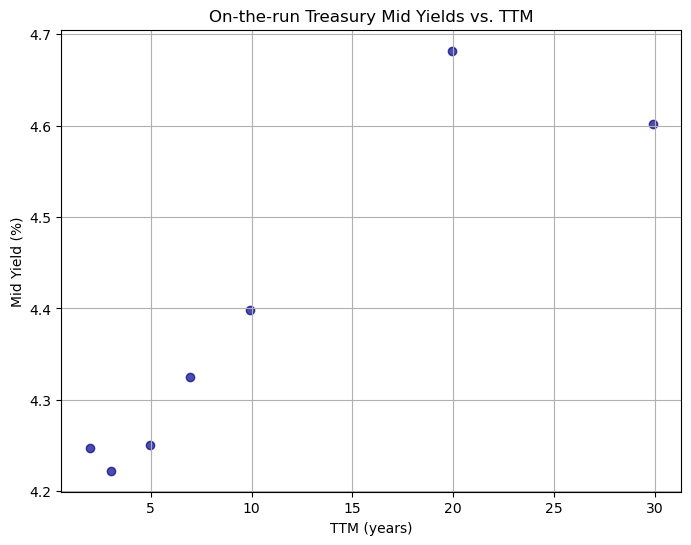

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(merged_us_treasuries_on_the_run["TTM"], merged_us_treasuries_on_the_run["midYield"], color="darkblue", alpha=0.7)
plt.xlabel("TTM (years)")
plt.ylabel("Mid Yield (%)")
plt.title("On-the-run Treasury Mid Yields vs. TTM")
plt.grid(True)
plt.show()

## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. 

Calibrate the bid, ask and mid discount factor curves as of 2024-12-13.

Display the calibration results for the mid curve, using get_yield_curve_details_df().

In [16]:
def calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column):
    ql.Settings.instance().evaluationDate = calc_date
    sorted_details_frame = treasury_details.sort_values(by='maturity')
    day_count = ql.ActualActual(ql.ActualActual.ISMA)
    bond_helpers = []
    for _, row in sorted_details_frame.iterrows():
        bond = create_bond_from_symbology(row)
        px = row[price_quote_column]
        bond_helpers.append(ql.BondHelper(ql.QuoteHandle(ql.SimpleQuote(px)), bond))
    curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    curve.enableExtrapolation()
    return curve

def get_yield_curve_details_df(curve, curve_dates=None):
    if curve_dates is None:
        curve_dates = curve.dates()
    d = []
    for dt_ in curve_dates:
        d.append((dt_.to_date(),
                  round(curve.timeFromReference(dt_), 3),
                  round(curve.discount(dt_), 3),
                  round(curve.zeroRate(dt_, curve.dayCounter(), ql.Compounded).rate()*100, 3)))
    return pd.DataFrame(d, columns=["Date","YearFrac","DiscountFactor","ZeroRate"])

In [17]:
bid_curve = calibrate_yield_curve_from_frame(calc_date, merged_us_treasuries_on_the_run, "bidPrice")
ask_curve = calibrate_yield_curve_from_frame(calc_date, merged_us_treasuries_on_the_run, "askPrice")
mid_curve = calibrate_yield_curve_from_frame(calc_date, merged_us_treasuries_on_the_run, "midPrice")

mid_curve_details_df = get_yield_curve_details_df(mid_curve)
display(mid_curve_details_df)

,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

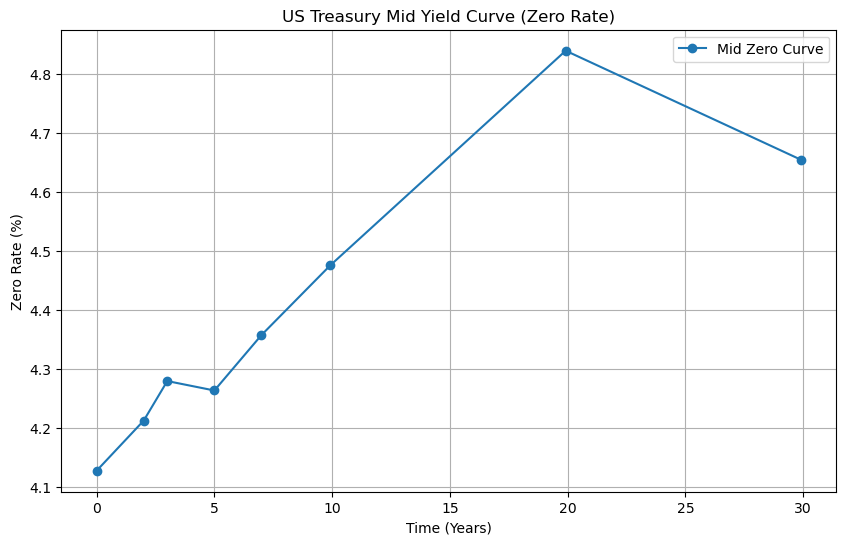

In [32]:
mid_curve_details_df = mid_curve_details_df.sort_values(by='YearFrac')
plt.figure(figsize=(10, 6))
plt.plot(mid_curve_details_df['YearFrac'], mid_curve_details_df['ZeroRate'], marker='o', label='Mid Zero Curve')

plt.xlabel('Time (Years)')
plt.ylabel('Zero Rate (%)')
plt.title('US Treasury Mid Yield Curve (Zero Rate)')
plt.grid(True)
plt.legend()
plt.show()

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

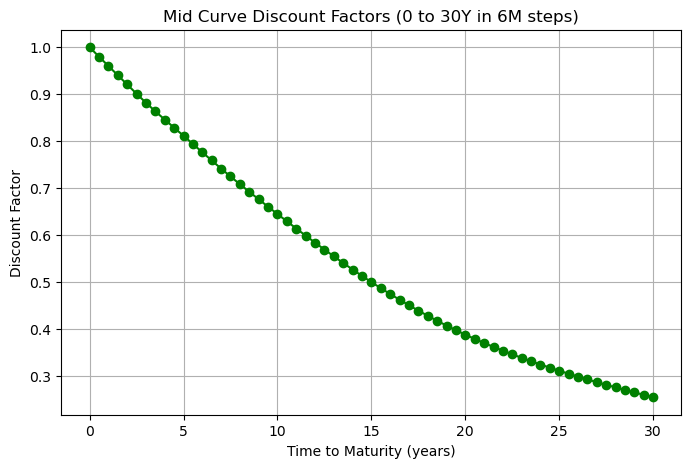

In [19]:
ts = []
dfs = []
for i in range(61):
    t = 0.5 * i
    ddate = mid_curve.referenceDate() + ql.Period(int(6*i), ql.Months)
    if t <= 30.0:
        disc = mid_curve.discount(ddate)
        ts.append(t)
        dfs.append(disc)

plt.figure(figsize=(8, 5))
plt.plot(ts, dfs, marker="o", linestyle="-", color="green")
plt.title("Mid Curve Discount Factors (0 to 30Y in 6M steps)")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Discount Factor")
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------
# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Bond Present Value Calculation (no credit risk)" in the QuantLib Basic notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid_price |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [20]:
df_otr = merged_us_treasuries_on_the_run.copy()
tsy_engine_mid = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(mid_curve))
calc_prices = []
for _, row in df_otr.iterrows():
    bond_obj = create_bond_from_symbology(row)
    bond_obj.setPricingEngine(tsy_engine_mid)
    calc_prices.append(bond_obj.cleanPrice())
df_otr["calc_mid_price"] = calc_prices
display(df_otr[['calc_mid_price']])

,calc_mid_price
0,98.82030
1,98.34375
2,100.00390
3,99.44140
4,98.80470
5,99.26565
6,99.37890


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 7. "Analytics Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [21]:
day_count_govt = ql.ActualActual(ql.ActualActual.ISMA)
compounding = ql.Compounded
freq = ql.Semiannual
dur_list = []
conv_list = []
dv01_list = []
for _, row in df_otr.iterrows():
    b = create_bond_from_symbology(row)
    flat_rate = row["midYield"] / 100.0
    interest_rate = ql.InterestRate(flat_rate, day_count_govt, compounding, freq)
    engine_flat = ql.DiscountingBondEngine(
        ql.YieldTermStructureHandle(
            ql.FlatForward(calc_date, ql.QuoteHandle(ql.SimpleQuote(flat_rate)), day_count_govt, compounding, freq)
        )
    )
    b.setPricingEngine(engine_flat)
    dirty_price = b.dirtyPrice()
    duration = ql.BondFunctions.duration(b, interest_rate, ql.Duration.Modified)
    convexity = ql.BondFunctions.convexity(b, interest_rate)
    dv01 = dirty_price * duration
    dur_list.append(duration)
    conv_list.append(convexity)
    dv01_list.append(dv01)
df_otr["duration"] = dur_list
df_otr["convexity"] = conv_list
df_otr["dv01"] = dv01_list
display(df_otr[['dv01', 'duration', 'convexity']])

,dv01,duration,convexity
0,791.272065,7.975950,75.888085
1,1597.153704,16.172044,377.793785
2,185.583759,1.855091,4.415195
3,440.600604,4.429385,22.942927
4,590.192703,5.971501,41.654301
5,1280.263863,12.842899,218.617062
6,277.805619,2.794451,9.412534


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [22]:
interest_bump = ql.SimpleQuote(0.0)
scenario_curve = ql.ZeroSpreadedTermStructure(
    ql.YieldTermStructureHandle(mid_curve),
    ql.QuoteHandle(interest_bump),
    ql.Compounded,
    ql.Semiannual
)
scenario_curve_handle = ql.YieldTermStructureHandle(scenario_curve)
scenario_engine = ql.DiscountingBondEngine(scenario_curve_handle)

scen_dv01_vals = []
scen_dur_vals = []
scen_cvx_vals = []
for _, row in df_otr.iterrows():
    b = create_bond_from_symbology(row)
    b.setPricingEngine(tsy_engine_mid)
    p0 = b.cleanPrice()
    dp0 = b.dirtyPrice()
    interest_bump.setValue(0.0001)
    b.setPricingEngine(scenario_engine)
    p_up = b.cleanPrice()
    interest_bump.setValue(-0.0001)
    b.setPricingEngine(scenario_engine)
    p_dn = b.cleanPrice()
    interest_bump.setValue(0.0)
    b.setPricingEngine(scenario_engine)
    
    dv01_scen = (p_dn - p0) * 1e4 / 100
    dur_scen = dv01_scen / dp0 * 100
    gamma_1bp = (p_dn - 2.0 * p0 + p_up) * 1e8 / 100
    cvx_scen = gamma_1bp / dp0 * 100

    scen_dv01_vals.append(dv01_scen)
    scen_dur_vals.append(dur_scen)
    scen_cvx_vals.append(cvx_scen)

df_otr["scen_dv01"] = scen_dv01_vals
df_otr["scen_duration"] = scen_dur_vals
df_otr["scen_convexity"] = scen_cvx_vals

display(df_otr[['scen_dv01','scen_duration', 'scen_convexity']])

,scen_dv01,scen_duration,scen_convexity
0,7.900077,7.965052,75.660352
1,15.894651,16.099255,375.163956
2,1.894680,1.891073,4.566983
3,4.449579,4.466430,23.279837
4,5.947311,6.008234,42.087208
5,12.699533,12.742640,215.623560
6,2.772263,2.789281,9.378319


------------------------------------------------------------------------------------------
# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the fixed-rate corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects. 

Display the future cashflows for the `AAPL 2.2 09/11/29` bond.

In [23]:
corporate_fixed_bonds = bond_symbology[(bond_symbology["class"] == "Corp") & (bond_symbology["cpn_type"]=="FIXED")]

merged_corporate_bonds = pd.merge(corporate_fixed_bonds,
    bond_market_prices_eod,
    on=["ticker","isin","figi"],
    how="inner"
)
merged_corporate_bonds = merged_corporate_bonds.drop(columns=["class_y"])
merged_corporate_bonds.rename(columns={"class_x": "class"}, inplace=True)
merged_corporate_bonds["midPrice"] = (merged_corporate_bonds["bidPrice"] + merged_corporate_bonds["askPrice"])/2
merged_corporate_bonds["midYield"] = (merged_corporate_bonds["bidYield"] + merged_corporate_bonds["askYield"])/2

In [24]:
aapl_22_09_11_29 = merged_corporate_bonds[merged_corporate_bonds["security"].str.contains("AAPL 2.2 09/11/29", regex=False)].iloc[0]
aapl_bond_obj = create_bond_from_symbology(aapl_22_09_11_29.to_dict())
aapl_cf_df = get_bond_cashflows(aapl_bond_obj, calc_date)
display(aapl_cf_df)

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"March 11th, 2025",1.1,0.244444
1,"September 11th, 2025",1.1,0.744444
2,"March 11th, 2026",1.1,1.244444
3,"September 11th, 2026",1.1,1.744444
4,"March 11th, 2027",1.1,2.244444
5,"September 11th, 2027",1.1,2.744444
6,"March 11th, 2028",1.1,3.244444
7,"September 11th, 2028",1.1,3.744444
8,"March 11th, 2029",1.1,4.244444
9,"September 11th, 2029",1.1,4.744444


## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [25]:
day_count = ql.ActualActual(ql.ActualActual.ISMA)
compounding = ql.Compounded
freq = ql.Semiannual
calc_yields = []
calc_zspreads = []
tsy_curve_handle = ql.YieldTermStructureHandle(mid_curve)
for i, r in merged_corporate_bonds.iterrows():
    b = create_bond_from_symbology(r)
    px = r["midPrice"]
    yld = ql.BondFunctions.bondYield(b, px, day_count, compounding, freq)
    zspr = ql.BondFunctions.zSpread(b, px, mid_curve, day_count, compounding, freq)
    calc_yields.append(yld)
    calc_zspreads.append(zspr)
merged_corporate_bonds["calc_yield"] = calc_yields
merged_corporate_bonds["calc_zspread"] = calc_zspreads
display(merged_corporate_bonds[['calc_yield','calc_zspread']].head())

,calc_yield,calc_zspread
0,0.051307,0.004421
1,0.049976,0.003093
2,0.051702,0.004690
3,0.051568,0.004722
4,0.043827,0.003825


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

For the following corporate bonds:

* `IBM 1.95 05/15/30`
* `ORCL 2 7/8 03/25/31`
* `DIS 6.65 11/15/37`

use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)".

Validate/confirm that you match the original market prices, which were used as input to the z-Spread function.


In [26]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price

In [27]:
corp_bonds_validation = ["IBM 1.95 05/15/30","ORCL 2 7/8 03/25/31","DIS 6.65 11/15/37"]
df_validation = merged_corporate_bonds[merged_corporate_bonds["security"].isin(corp_bonds_validation)]
reprice_results = []
for _, row in df_validation.iterrows():
    b_obj = create_bond_from_symbology(row)
    z_val = row["calc_zspread"]
    p_calc = calc_clean_price_with_zspread(b_obj, tsy_curve_handle, z_val)
    reprice_results.append((row["security"], round(row["midPrice"],4), round(p_calc,4)))
df_validation_results = pd.DataFrame(reprice_results, columns=["Bond","MarketMidPrice","RepriceWithZSpread"])
display(df_validation_results)

,Bond,MarketMidPrice,RepriceWithZSpread
0,DIS 6.65 11/15/37,113.3845,113.3845
1,IBM 1.95 05/15/30,86.4350,86.4350
2,ORCL 2 7/8 03/25/31,88.7085,88.7085


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|

Display the head of the dataframe.

Scatter plot duration and convexity by TTM for all AAPL (fixed-rate) bonds.

In [28]:
calc_durations = []
calc_convexities = []
for i, r in merged_corporate_bonds.iterrows():
    b = create_bond_from_symbology(r)
    rate = ql.InterestRate(r["calc_yield"], day_count, compounding, freq)
    d = ql.BondFunctions.duration(b, rate, ql.Duration.Modified)
    c = ql.BondFunctions.convexity(b, rate)
    calc_durations.append(d)
    calc_convexities.append(c)
merged_corporate_bonds["calc_duration"] = calc_durations
merged_corporate_bonds["calc_convexity"] = calc_convexities
display(merged_corporate_bonds.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,askPrice,accrued,bidYield,askYield,midPrice,midYield,calc_yield,calc_zspread,calc_duration,calc_convexity
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,85.148,0.4490,5.157,5.105,84.8670,5.1310,0.051307,0.004421,12.455202,200.832785
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,93.617,0.4940,5.030,4.966,93.2430,4.9980,0.049976,0.003093,12.558637,208.897308
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,78.915,1.2170,5.200,5.143,78.6120,5.1715,0.051702,0.004690,13.315126,233.649174
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,90.517,0.4010,5.184,5.130,90.1970,5.1570,0.051568,0.004722,12.913848,223.508106
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,98.771,1.0205,4.455,4.321,98.6945,4.3880,0.043827,0.003825,1.138479,1.871877


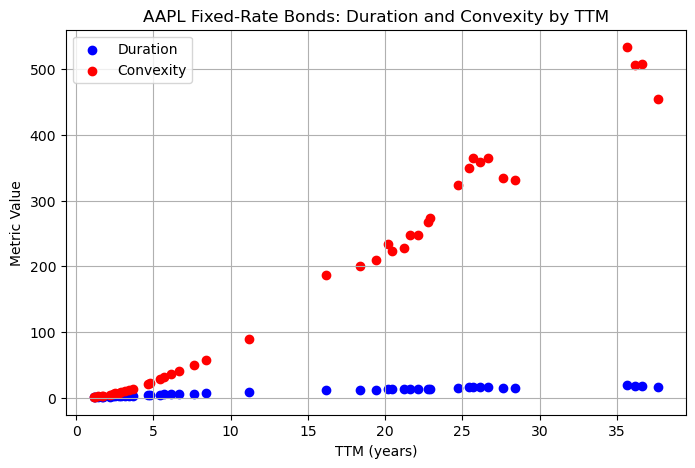

In [29]:
aapl_bonds = merged_corporate_bonds[merged_corporate_bonds["ticker"]=="AAPL"]
plt.figure(figsize=(8,5))
plt.scatter(aapl_bonds["TTM"], aapl_bonds["calc_duration"], c="blue", label="Duration")
plt.scatter(aapl_bonds["TTM"], aapl_bonds["calc_convexity"], c="red", label="Convexity")
plt.xlabel("TTM (years)")
plt.ylabel("Metric Value")
plt.title("AAPL Fixed-Rate Bonds: Duration and Convexity by TTM")
plt.legend()
plt.grid(True)
plt.show()